In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
X = np.random.normal(loc=0, scale=1, size=(500, 10))
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as accuracy
from sklearn.tree import DecisionTreeClassifier

In [167]:
def compute_y(x):
    if (np.linalg.norm(x))**2 >= 9.34:
        return 1
    else:
        return -1
Y = np.empty((500))
for y in range(0,500):
    Y[y]=compute_y(X[y])
Y = Y.astype(int)

In [168]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,label=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.label = label
    def is_terminal(self):
        return self.label is not None

In [169]:

class DecisionTree:
    def __init__(self, max_depth=100, min_samples_split=2,scoring='entropy',sample_weight=None):
      self.max_depth = max_depth
      self.min_samples_split = min_samples_split
      self.scoring=scoring
      self.root = None
      self.sample_weight=sample_weight

    def bincount_with_weights(self,y, sample_weight):
      unique_vals, inverse_indices, counts = np.unique(y, return_inverse=True, return_counts=True)
      weighted_counts = np.bincount(inverse_indices, weights=sample_weight)
      return unique_vals, weighted_counts
    def score(self, y,sample_weight):
      if self.scoring == 'gini':
        return self.gini_index(y,sample_weight)
      if self.scoring == 'entropy':
        return self.entropy(y,sample_weight)
      if self.scoring == 'mer':
        return self.mer(y,sample_weight)

    def is_finished(self, depth):
      if (depth >= self.max_depth or self.n_class_labels == 1 or self.n_samples < self.min_samples_split):
        return True
      return False
    
    def entropy(self, y,sample_weight):
      if sample_weight is not None:
        un_elem,prob = self.bincount_with_weights(y, sample_weight)
        prob=prob/len(y)
      else:
        prob = np.bincount(y) / len(y)
      return -np.sum([p * np.log2(p) for p in prob if p > 0])
      

    def gini_index(self,y,sample_weight):
      if sample_weight is not None:
        un_elem,prob = self.bincount_with_weights(y, sample_weight)
        prob=prob/len(y)
      else:
        prob = np.bincount(y) / len(y)
      return 1-np.sum(prob**2)

    def mer(self,y,sample_weight):
      if sample_weight is not None:
        un_elem,prob = self.bincount_with_weightss(y, sample_weight)
        prob=prob/len(y)
      else:
        prob = np.bincount(y) / len(y)
      j=np.argmax(prob)
      
      return 1-prob[j]

    def create_split(self, X, thresh):
      l_idx = np.argwhere(X <= thresh).flatten()
      r_idx = np.argwhere(X > thresh).flatten()
      return l_idx, r_idx
        

    def goodness(self, X, y, thresh,sample_weight):
      parent_loss = self.score(y,sample_weight)
      l_idx, r_idx = self.create_split(X, thresh)
      n, n_left, n_right = len(y), len(l_idx), len(r_idx)
      if n_left == 0 or n_right == 0: 
        return 0
      
      child_loss = (n_left / n) * self.score(y[l_idx],sample_weight[l_idx]) + (n_right / n) * self.score(y[r_idx],sample_weight[r_idx])
      return parent_loss - child_loss

    def best_split(self, X, y, features,sample_weight):

      split = {'score': -1, 'feat': None, 'thresh': None}

      for feat in features:
        X_feat = X[:, feat]
        thresholds = np.unique(X_feat)
        for thresh in thresholds:
          score = self.goodness(X_feat, y, thresh,sample_weight)
          if score > split['score']:
            split['score'] = score
            split['feat'] = feat
            split['thresh'] = thresh
      return split['feat'], split['thresh']


    def build_tree(self, X, y, sample_weight,depth=0,forest=0):
      self.n_samples, self.n_features = X.shape
      self.n_class_labels = len(np.unique(y))
      if(forest == 1):  ### for random forest
        self.feats=[]
        for i in range(self.n_features):
          if(np.random.randint(2)):
            self.feats.append(i)
        if(len(self.feats)==0):
          self.feats=range(self.n_features)
      else:
        self.feats=range(self.n_features)
      # stopping criteria
      if self.is_finished(depth):
        if sample_weight is not None:
          un_elem,prob = self.bincount_with_weights(y, sample_weight)
          most_common_Label = un_elem[np.argmax(prob)]
        else:
          most_common_Label = np.argmax(np.bincount(y))
        return Node(label=most_common_Label)  
      #get best split
      best_feat, best_thresh = self.best_split(X, y, self.feats,sample_weight)

      # grow children recursively
      l_idx, r_idx = self.create_split(X[:, best_feat], best_thresh)
      if(len(r_idx) ==0 or len(l_idx) ==0):
        if sample_weight is not None:
          un_elem,prob = self.bincount_with_weights(y, sample_weight)
          most_common_Label = un_elem[np.argmax(prob)]
        else:
          most_common_Label = np.argmax(np.bincount(y))
        return Node(label=most_common_Label)
      else :
        left_child = self.build_tree(X[l_idx, :], y[l_idx],sample_weight[l_idx] ,depth + 1)
        right_child = self.build_tree(X[r_idx, :], y[r_idx],sample_weight[r_idx] ,depth + 1)
        return Node(best_feat, best_thresh, left_child, right_child)

    def fit(self, X, y,sample_weight=None,forest=0):
      if sample_weight is not None:
        self.root = self.build_tree(X, y,sample_weight,0,forest)
      else:
        self.root = self.build_tree(X, y,np.full((X.shape[0]),1),0,forest)

    def traverse(self, x, node):
      if node.is_terminal():
        return node.label
      if x[node.feature] <= node.threshold:
        return self.traverse(x, node.left)
      return self.traverse(x, node.right)

    def predict(self, X):
      predictions = [self.traverse(x, self.root) for x in X]
      return np.array(predictions)

In [170]:
X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.3,
        )

In [171]:
tree = DecisionTree(max_depth=1,scoring='entropy')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.5333333333333333


In [172]:
def Boosting(X,Y,iteration):
    n_samples,n_features=X.shape
    y=Y
    w = np.full(n_samples,1/n_samples)
    misc=np.empty((iteration,1))
    outp=np.zeros((n_samples))
    a=np.empty((iteration,1))
    iter=np.empty((iteration,1))
    for k in range(iteration):
        tree=DecisionTree(max_depth=1)
        tree.fit(X,y,w)
        y_pred=tree.predict(X)
        err=0
        for j in range(0,n_samples):
            if(Y[j]!=y_pred[j]):
                err+=w[j]
        err/=np.sum(w)
        a[k]=0.5*np.log((1-err)/(err))
        for j in range(0,n_samples):
            if(Y[j]!=y_pred[j]):
                w[j]*= np.exp(a[k])
        outp+=a[k]*y_pred
        mis=0
        for j in range(n_samples):
            if(outp[j]>=0 and Y[j]!=1):
                mis+=1
            if(outp[j]<0 and Y[j]!=-1):
                mis+=1
        misc[k]= mis/n_samples
        iter[k]=k
    return misc,iter

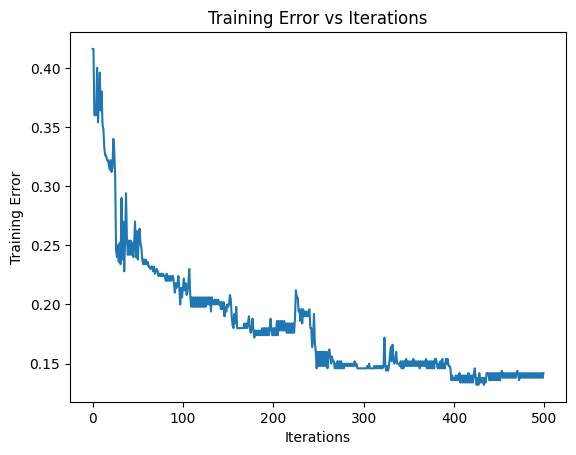

FInal Error [0.142]


In [173]:
A=Boosting(X,Y,500)
misc=A[0]
iter=A[1]
plt.plot(iter,misc,label = 'Classifier line')
plt.xlabel('Iterations')
plt.ylabel('Training Error') 
plt.title("Training Error vs Iterations")
plt.show()
print("FInal Error",misc[-1])